In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt

# import mxnet as mx


Using Theano backend.


In [2]:
base_image_path = "vango2.jpg"
style_reference_image_path = "vango2.jpg"
# result_prefix = "res"
iterations = 30

total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025 * 4 * 4

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

In [3]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    print img.shape
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 128#103.939
    x[:, :, 1] += 128#116.779
    x[:, :, 2] += 128#123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_nrows, img_ncols, 3))



(1, 224, 224, 3)
(1, 224, 224, 3)


In [4]:
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])



Model loaded.


In [5]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))



In [6]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict['block4_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)




In [7]:
# # def gram_matrix(x):
# #     assert K.ndim(x) == 3
# #     features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
# #     gram = K.dot(features, K.transpose(features))
# #     return gram

# # def style_loss(style, combination):
# #     assert K.ndim(style) == 3
# #     assert K.ndim(combination) == 3
# #     S = gram_matrix(style)
# #     C = gram_matrix(combination)
# #     channels = 3
# #     size = 224*224#img_nrows * img_ncols
# #     return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# def gram_matrix(x):
#     assert K.ndim(x) == 3
#     features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
#     gram = K.dot(features, K.transpose(features))
#     return gram


# def style_loss(style, combination):
#     assert K.ndim(style) == 3
#     assert K.ndim(combination) == 3
#     S = gram_matrix(style)
#     C = gram_matrix(combination)
#     channels = 3
#     size = img_nrows * img_ncols
#     return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# # an auxiliary loss function
# # designed to maintain the "content" of the
# # base image in the generated image


# def content_loss(base, combination):
#     return K.mean(K.square(combination - base), axis=-1)

# # the 3rd loss function, total variation loss,
# # designed to keep the generated image locally coherent

# def total_variation_loss(x):
#     assert K.ndim(x) == 4
#     a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
#     b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
#     return K.sum(K.pow(a + b, 1.25))



In [8]:
# # combine these loss functions into a single scalar
# loss = K.variable(0.)
# layer_features = outputs_dict['block4_conv2']
# base_image_features = layer_features[0, :, :, :]
# combination_features = layer_features[2, :, :, :]
# loss += content_weight * content_loss(base_image_features,
#                                       combination_features)

# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']
# for layer_name in feature_layers:
#     layer_features = outputs_dict[layer_name]
#     style_reference_features = layer_features[1, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     sl = style_loss(style_reference_features, combination_features)
#     loss += (style_weight / len(feature_layers)) * sl
# loss += total_variation_weight * total_variation_loss(combination_image)

# # grads = K.gradients(loss, combination_image)

# outputs = [loss]
# # if isinstance(grads, (list, tuple)):
# #     outputs += grads
# # else:
# #     outputs.append(grads)

# f_outputs = K.function([combination_image], outputs)




In [9]:
# base_image_path = "building.jpg"
# style_reference_image_path = "vango2.jpg"
# # result_prefix = "res"
# iterations = 30

# total_variation_weight = 1.0
# style_weight = 1.0
# content_weight = 0.025 * 4 * 4

# width, height = load_img(base_image_path).size
# img_nrows = 224
# img_ncols = 224#int(width * img_nrows / height)

In [10]:
# def preprocess_image(image_path):
#     img = load_img(image_path, target_size=(img_nrows, img_ncols))
#     img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img)
#     return img

# base_image = K.variable(preprocess_image(base_image_path))
# style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# combination_image = K.placeholder((1, img_nrows, img_ncols, 3))



In [11]:
# input_tensor = K.concatenate([base_image,
#                               style_reference_image,
#                               combination_image], axis=0)

# model1 = vgg16.VGG16(input_tensor=input_tensor,
#                     weights='imagenet', include_top=False)
# print('Model loaded.')

# # get the symbolic outputs of each "key" layer (we gave them unique names).
# outputs_dict = dict([(layer.name, layer.output) for layer in model1.layers])



In [12]:
def get_loss(y_true, y_pred):
    print "yT", y_true
    print "yP", y_pred
    loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    print "loss", K.shape(loss), loss
    return loss

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


# def my_loss(y_true, y_pred):
#     model1 = vgg16.VGG16(weights='imagenet', include_top=False)
#     print type(y_true), y_true
#     out_true = model1.predict(y_true)
#     out_pred = model1.predict(y_pred)
# #     return K.variable(0.)
#     return get_loss(out_true, out_pred)
import tensorflow as tf

sess = tf.InteractiveSession()
graph = tf.get_default_graph()

def my_loss_2(y_true, y_pred):
    print K.shape (y_pred)
    outs = f_outputs([K.eval(y_pred)])
    loss_value = outs[0]
    return loss_value



def get_actual_loss(y_true, y_pred):
#     return mean_squared_error(y_true, y_pred)

#     img11 = vgg16.preprocess_input(y_pred)
    combination_image = y_pred#K.variable(img11)
    style_reference_image = y_true
#     base_image = K.variable(preprocess_image(base_image_path))
    
    input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

    model1 = vgg16.VGG16(input_tensor=input_tensor,
                        weights='imagenet', include_top=False)
#     print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model1.layers])

    
    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features,
                                          combination_features)
    return loss
#     feature_layers = ['block1_conv1', 'block2_conv1',
#                       'block3_conv1', 'block4_conv1',
#                       'block5_conv1']
#     for layer_name in feature_layers:
#         layer_features = outputs_dict[layer_name]
#         style_reference_features = layer_features[1, :, :, :]
#         combination_features = layer_features[2, :, :, :]
#         sl = style_loss(style_reference_features, combination_features)
#         loss += (style_weight / len(feature_layers)) * sl
#     loss += total_variation_weight * total_variation_loss(combination_image)
#     return loss
#     outputs = [loss]

#     f_outputs = K.function([combination_image], outputs)
#     outs = f_outputs([combination_image])
#     loss_value = outs[0]
#     return loss_value



In [13]:
# print type(inpY)
# print my_loss_2(inpY, inpY)

In [37]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))
inputs_ = Input(shape=( 224,224,3, ))


# Layer 1
x1 = Dense(1000, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(16*7*7, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
# x = Reshape((16, 7, 7))(x)
x = Reshape((7, 7, 16))(x)

# Layer 3
x = UpSampling2D(size = (2, 2), dim_ordering = 'tf')(x) #shape is (16, 14, 14)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 4
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 5
x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) # 28, 28 -> 224, 224
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

vgg_model = VGG16(weights = 'imagenet', include_top = False)
for layer in vgg_model.layers:
    layer.trainable = False
outp_vgg = vgg_model.output

# Discriminative model
disc_model = Model(input = vgg_model.input, output = vgg_model.layers[8].output)

In [38]:
# model = Sequential()
# model.add(generative_model)
# model.add(disc_model)

In [40]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
# img = inp
# print img.shape
# # img = img.swapaxes(0, 2)#.swapaxes(0, 1)
# plt.imshow(img )
# plt.show()



# inp = inp.swapaxes(0, 1)
print "basic", inp.shape
inpY = 1.0 * np.reshape(inp, (1,224, 224, 3)) 
# trainY = disc_model.predict([inp])
# trainY2 = disc_model.predict([inp * 1.0/256])
# print trainY2.shape

# import Image
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
# inp = inp.swapaxes(0, 1)
trainX = np.reshape(inp, (1, 224, 224, 3))
# trainX = disc_model.predict([inp])

trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))

trainX3 = trainX2 * 1.0/256

# trainX3 = trainX * 1.0/256


inpY = inpY*1.0 / 256
print trainX3.shape
print inpY.shape

basic (50176, 3)
(1, 150528)
(1, 224, 224, 3)


In [41]:
# print trainX3
# print ""
# print inpY

In [42]:
# import keras
# adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# # sgd = SGD(lr=5, momentum=0.9, nesterov=True)
# model.compile(loss = get_loss
#               , optimizer = adam_op)

In [43]:
# model.fit(trainX3, trainY2, nb_epoch = 0)
# # generative_model.summary()

In [45]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(loss = 'mae'
              ,optimizer = adam_op)
# print trainX3.shape, inpY.shape


Epoch 1/1
1/1 [==============================] - 4s - loss: 0.1728
(224, 224, 3)


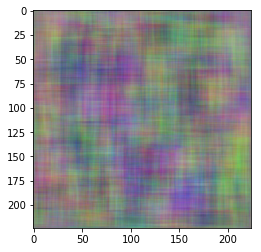

Epoch 1/1
1/1 [==============================] - 2s - loss: 0.1705
(224, 224, 3)


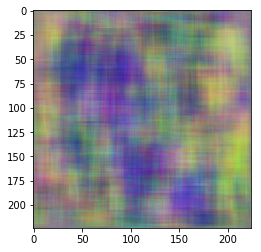

Epoch 1/1
1/1 [==============================] - 2s - loss: 0.1643
(224, 224, 3)


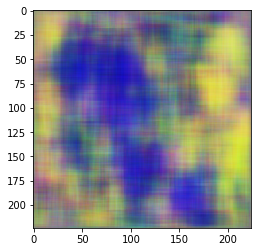

Epoch 1/1
1/1 [==============================] - 2s - loss: 0.1503
(224, 224, 3)


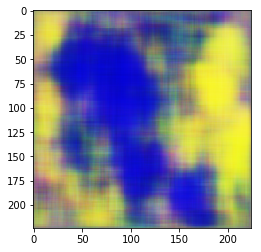

Epoch 1/1


In [ ]:
for i in range(10):
    generative_model.fit(trainX3, inpY, nb_epoch = 1)
    img = generative_model.predict(trainX3)
    img = img[0]
    print img.shape
    # img = img.swapaxes(0, 2)#.swapaxes(0, 1)
    plt.imshow(img)
    plt.show()
 

In [115]:
print img

[[[ 0.55651873  0.49313539  0.47506484]
  [ 0.58360672  0.49085802  0.43562168]
  [ 0.60292572  0.48184955  0.44130376]
  ..., 
  [ 0.5538736   0.49722651  0.42526194]
  [ 0.55506063  0.4905763   0.43438077]
  [ 0.53263301  0.47828314  0.45720267]]

 [[ 0.56564027  0.49118164  0.46112168]
  [ 0.59428936  0.48588923  0.40679282]
  [ 0.61296356  0.45828766  0.40579557]
  ..., 
  [ 0.55374044  0.4832769   0.39426231]
  [ 0.55715889  0.47571263  0.40274563]
  [ 0.53501058  0.46776119  0.42744207]]

 [[ 0.58675677  0.49442849  0.4348118 ]
  [ 0.61252707  0.49628714  0.37127161]
  [ 0.63962382  0.45764986  0.35695493]
  ..., 
  [ 0.5815931   0.44423082  0.33915174]
  [ 0.57848948  0.45355484  0.35779947]
  [ 0.5444808   0.44600904  0.39037281]]

 ..., 
 [[ 0.62747562  0.49344441  0.44219744]
  [ 0.66861111  0.51165807  0.35194632]
  [ 0.6793921   0.48100144  0.28004354]
  ..., 
  [ 0.82809848  0.2014095   0.08060972]
  [ 0.77736992  0.26790971  0.12073976]
  [ 0.70342916  0.31150714  0.17328